### Seq2Seq with attention

前面已经学习了Seq2Seq和注意力机制，现在把注意力机制引入到基本的Seq2Seq模型中。  
点积注意力公式中的x1在Seq2Seq中为解码器在各个时间步的隐藏状态，形状为(batch_size, seq_len1, feature_dim)；x2在Seq2Seq中则为编码器在各个时间步的隐藏状态，形状为(batch_size, seq_len1, feature_dim)，所以此时可以解释为解码器会在关注了编码器后重新生成一个x1(上下文向量)，解码器利用这个信息可以生成更准确的输出序列。  

<img src="./images/seq2seq_with_attention.png" alt="examples" style="zoom:34%;" />

#### seq2seq with attention的训练过程

> 1. 构建语料库

In [41]:
# 1.训练数据 每一组数据包含输入序列、解码器输入以及目标输出(解码器的输入是Teacher Forcing)
sentences = [
    ['咖哥 喜欢 小冰', '<sos> KaGe likes XiaoBing', 'KaGe likes XiaoBing <eos>'],
    ['我 爱 学习 人工智能', '<sos> I love studying AI', 'I love studying AI <eos>'],
    ['深度学习 改变 世界', '<sos> DL changed the world', 'DL changed the world <eos>'],
    ['自然 语言 处理 很 强大', '<sos> NLP is so powerful', 'NLP is so powerful <eos>'],
    ['神经网络 非常 复杂', '<sos> Neural-Nets are complex', 'Neural-Nets are complex <eos>']]

# 2.初始化中英文词汇表
word_list_cn, word_list_en = [], []
for s in sentences:
    word_list_cn.extend(s[0].split())
    word_list_en.extend(s[1].split())
    word_list_en.extend(s[2].split())

# 对词汇表进行去重
word_list_cn = list(set(word_list_cn))
word_list_en = list(set(word_list_en))

# 分别构建单词到索引的映射
word2idx_cn = {word: idx for idx,word in enumerate(word_list_cn)}
word2idx_en = {word: idx for idx,word in enumerate(word_list_en)}

idx2word_cn = {idx: word for idx,word in enumerate(word_list_cn)}
idx2word_en = {idx: word for idx,word in enumerate(word_list_en)}

# 计算词汇表的大小
voc_size_cn = len(word_list_cn)
voc_size_en = len(word_list_en)
print(" 句子数量：", len(sentences)) # 打印句子数
print(" 中文词汇表大小：", voc_size_cn) # 打印中文词汇表大小
print(" 英文词汇表大小：", voc_size_en) # 打印英文词汇表大小
print(" 中文词汇到索引的字典：", word2idx_cn) # 打印中文词汇到索引的字典
print(" 英文词汇到索引的字典：", word2idx_en) # 打印英文词汇到索引的字典

 句子数量： 5
 中文词汇表大小： 18
 英文词汇表大小： 20
 中文词汇到索引的字典： {'学习': 0, '神经网络': 1, '深度学习': 2, '世界': 3, '强大': 4, '处理': 5, '喜欢': 6, '我': 7, '爱': 8, '语言': 9, '非常': 10, '复杂': 11, '很': 12, '改变': 13, '人工智能': 14, '小冰': 15, '咖哥': 16, '自然': 17}
 英文词汇到索引的字典： {'the': 0, 'likes': 1, 'XiaoBing': 2, 'changed': 3, 'studying': 4, 'are': 5, 'AI': 6, 'love': 7, 'complex': 8, '<sos>': 9, 'DL': 10, 'NLP': 11, 'I': 12, 'KaGe': 13, 'powerful': 14, 'so': 15, '<eos>': 16, 'world': 17, 'is': 18, 'Neural-Nets': 19}


> 2. 生成训练数据

In [42]:
import numpy as np
import torch
import random

# 定义生成训练数据的函数
# 之所以没有batch是因为输入序列的长度不一致，如果将会数据变成batch那么需要padding等操作保证输入序列长度一致
# 否则torch.LongTensor(encoder_input)会报错
def make_data(sentences):
    selected_sentence = random.choice(sentences)
    # np.array([[1,2,3]]) -> shape[1,3]多维数据, 行数可以看作是batch_size
    encoder_input = np.array([[word2idx_cn[s] for s in selected_sentence[0].split()]])
    decoder_input = np.array([[word2idx_en[s] for s in selected_sentence[1].split()]])
    target = np.array([[word2idx_en[s] for s in selected_sentence[2].split()]])

    encoder_input = torch.LongTensor(encoder_input)
    decoder_input = torch.LongTensor(decoder_input)
    target = torch.LongTensor(target)

    return encoder_input, decoder_input, target

encoder_input, decoder_input, target = make_data(sentences)

# 打印choice的句子
for s in sentences:
    cur = [word2idx_cn[n] in encoder_input for n in s[0].split()]
    if all(cur):
        orginal_sentence = s
        break

# 打印信息:
print(" 原始句子：", orginal_sentence) # 打印原始句子
print(" 编码器输入张量的形状：", encoder_input.shape)  # 打印输入张量形状
print(" 解码器输入张量的形状：", decoder_input.shape) # 打印输出张量形状
print(" 目标张量的形状：", target.shape) # 打印目标张量形状
print(" 编码器输入张量：", encoder_input) # 打印输入张量
print(" 解码器输入张量：", decoder_input) # 打印输出张量
print(" 目标张量：", target) # 打印目标张量
print(target.view(-1))
print(encoder_input.size(1))


 原始句子： ['咖哥 喜欢 小冰', '<sos> KaGe likes XiaoBing', 'KaGe likes XiaoBing <eos>']
 编码器输入张量的形状： torch.Size([1, 3])
 解码器输入张量的形状： torch.Size([1, 4])
 目标张量的形状： torch.Size([1, 4])
 编码器输入张量： tensor([[16,  6, 15]])
 解码器输入张量： tensor([[ 9, 13,  1,  2]])
 目标张量： tensor([[13,  1,  2, 16]])
tensor([13,  1,  2, 16])
3


> 3. 定义attention

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
    def forward(self, encoder_hidden, decoder_hidden):
        # 计算点积
        raw_weight = torch.bmm(decoder_hidden, encoder_hidden.transpose(1,2))
        # 归一化
        attn_weight = F.softmax(raw_weight, dim=-1)
        # 加权和
        attn_output = torch.bmm(attn_weight, encoder_hidden)
        return attn_output,attn_weight

> 4. 定义encoder，重构decoder

In [44]:
# encoder部分跟seq2seq一致
class Encoder(nn.Module):
    def __init__(self, cn_input_size, embedding_size, hidden_size):
        super(Encoder, self).__init__()
        self.emdedding = nn.Embedding(cn_input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
    def forward(self, encoder_input, encoder_hidden):
        embedding = self.emdedding(encoder_input)
        output, hn = self.rnn(embedding, encoder_hidden)
        return output, hn

# decoder部分增加attention
class Decoder(nn.Module):
    def __init__(self, en_input_size, embedding_size, hidden_size):
        super(Decoder, self).__init__()
        # (1,4) -> (1,4,embedding_size) 1为batch_size
        self.emdedding = nn.Embedding(en_input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.attention = Attention()
        self.linear = nn.Linear(hidden_size * 2, en_input_size)
    def forward(self, decoder_input, encoder_output, encoder_hidden):
        embedding = self.emdedding(decoder_input)
        output, hn = self.rnn(embedding, encoder_hidden)
        attn_output, attn_weight = self.attention(encoder_output, output)
        de_output = torch.cat((output, attn_output), dim=-1)
        output = self.linear(de_output)
        return output, hn, attn_weight

# 设置各个层的数量
cn_input_size = voc_size_cn
en_input_size = voc_size_en
embedding_size = 10
hidden_size = 128

# 创建编码器和解码器
encoder = Encoder(cn_input_size, embedding_size, hidden_size)
decoder = Decoder(en_input_size, embedding_size, hidden_size)

print("编码器结构:", encoder)
print("解码器结构:", decoder)

编码器结构: Encoder(
  (emdedding): Embedding(18, 10)
  (rnn): RNN(10, 128, batch_first=True)
)
解码器结构: Decoder(
  (emdedding): Embedding(20, 10)
  (rnn): RNN(10, 128, batch_first=True)
  (attention): Attention()
  (linear): Linear(in_features=256, out_features=20, bias=True)
)


> 5. 定义seq2seq with attention结构

In [45]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, cn_input, cn_hidden, en_input):
        output, hidden = self.encoder(cn_input, cn_hidden)
        decoder_output, _, attn_weight = self.decoder(en_input, output, hidden)
        return decoder_output, attn_weight

model = Seq2Seq(encoder, decoder)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (emdedding): Embedding(18, 10)
    (rnn): RNN(10, 128, batch_first=True)
  )
  (decoder): Decoder(
    (emdedding): Embedding(20, 10)
    (rnn): RNN(10, 128, batch_first=True)
    (attention): Attention()
    (linear): Linear(in_features=256, out_features=20, bias=True)
  )
)


> 6. 模型训练

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 400
def train_seq2seq(model, criterion, optimizer, epochs):
    for epoch in range(epochs):
        encoder_input, decoder_input, target = make_data(sentences) # 获得训练数据
        encoder_hidden = torch.zeros(1, encoder_input.size(0), hidden_size)# 初始化encoder的隐藏状态
        optimizer.zero_grad() # 梯度清零
        output, _ = model(encoder_input, encoder_hidden, decoder_input)
        loss = criterion(output.view(-1, voc_size_en), target.view(-1))
        if (epoch + 1) % 40 == 0: # 打印损失
            print(f"Epoch: {epoch + 1:04d} cost = {loss:.6f}")     
        loss.backward()
        optimizer.step()
train_seq2seq(model, criterion, optimizer, epochs)

Epoch: 0040 cost = 0.000752
Epoch: 0080 cost = 0.000409
Epoch: 0120 cost = 0.000142
Epoch: 0160 cost = 0.000088
Epoch: 0200 cost = 0.000086
Epoch: 0240 cost = 0.000063
Epoch: 0280 cost = 0.000076
Epoch: 0320 cost = 0.000062
Epoch: 0360 cost = 0.000037
Epoch: 0400 cost = 0.000030


> 7. 可视化注意力权重

In [50]:
# 创建一个可视化函数
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"]=['Arial Unicode MS'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号

def visualize_attention(source_sentence, predicted_sentence, attn_weights):    
    plt.figure(figsize=(10, 10)) # 画布
    ax = sns.heatmap(attn_weights, annot=True, cbar=False, 
                     xticklabels=source_sentence.split(), 
                     yticklabels=predicted_sentence, cmap="Greens") # 热力图
    plt.xlabel(" 源序列 ") 
    plt.ylabel(" 目标序列 ")
    plt.show() # 显示图片

自然 语言 处理 很 强大 -> ['NLP', 'is', 'so', 'powerful', '<eos>']


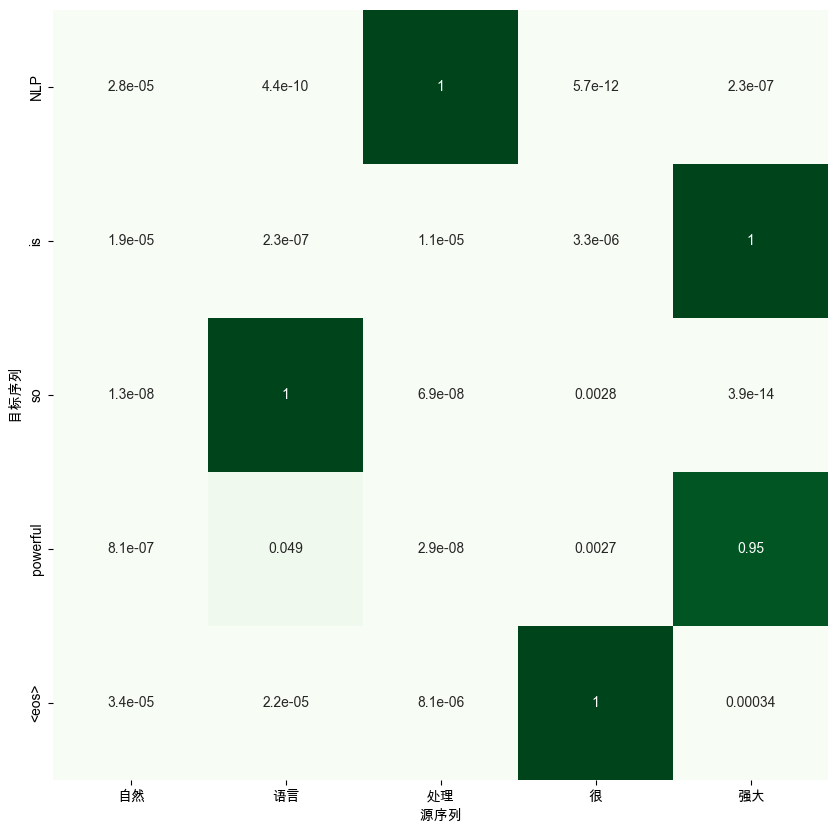

In [63]:
# 预测
def predict_sentence(model, source_sentence):
    encoder_input = np.array([[word2idx_cn[word] for word in source_sentence.split()]])
    decoder_input = np.array([word2idx_en['<sos>']] + [word2idx_en['<eos>']]*(len(encoder_input[0])-1))
    encoder_input = torch.LongTensor(encoder_input)
    decoder_input = torch.LongTensor(decoder_input).unsqueeze(0)
    # (rnn层数, batch_size, hidden_size)
    hidden = torch.zeros(1, encoder_input.size(0), hidden_size)
    # 此时的predict包含张量数据以及梯度信息，所以需要通过.data来获取数据部分
    predict, attn_weights = model(encoder_input, hidden, decoder_input)
    predict = predict.data.max(2, keepdim=True)[1] # 获取概率最大的索引
    # predict.squeeze() torch.Size([1, 5, 1]) -> torch.Size([5])
    print(source_sentence, '->', [idx2word_en[n.item()] for n in predict.squeeze()])
    # 通过cpu()方法将计算结果从gpu移动到cpu上，detach()用于创建一个新的张量，该张量与原始张量共享数据
    attn_weights = attn_weights.squeeze(0).cpu().detach().numpy()
    visualize_attention(source_sentence, [idx2word_en[n.item()] for n in predict.squeeze()], attn_weights)   
    
predict_sentence(model, "自然 语言 处理 很 强大")